<a href="https://colab.research.google.com/github/ysj9909/GANs/blob/main/Generative_Adversarial_Text2Img_Synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generative Adversarial Text to Image Synthesis code practice**
 
 * paper link : https://arxiv.org/pdf/1605.05396.pdf
 * dataset link : http://www.vision.caltech.edu/visipedia/CUB-200-2011.html
 * my review link : https://blog.naver.com/wsz87/222626406851

In [1]:
import os
import pickle
import nltk
from collections import Counter

nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/drive


In [2]:
cd drive/My Drive/pytorch-tutorial/GANs/GAT2IS/CUB_200_2011/CUB_200_2011

/content/drive/My Drive/pytorch-tutorial/GANs/GAT2IS/CUB_200_2011/CUB_200_2011


In [3]:
import os
from PIL import Image

image_dir = "./resized_dataset/Images"
size = [64, 64]

def resize_image(image, size):
  return image.resize(size, Image.ANTIALIAS)

if not os.path.exists(image_dir):
  os.makedirs(image_dir)

In [ ]:
num_imgs = 0
for i, f_ in enumerate(sorted(os.listdir())):
  for j, path in enumerate(sorted(os.listdir(f_))):
    if j < 30:
      num_imgs += 1
      with open(os.path.join(f_, path), "rb+") as f:
        with Image.open(f) as img:
          img = resize_image(img, size)
          img.save(os.path.join(image_dir, path), img.format)
  if (i + 1) % 10 == 0:
    print(f"[{i + 1} / {200}] Resized the images and saved {num_imgs} images.")

In [5]:
class Vocabulary(object):
  def __init__(self):
    self.word2idx = {}
    self.idx2word = {}
    self.idx = 0

  def add_word(self, word):
    if not word in self.word2idx:
      self.word2idx[word] = self.idx
      self.idx2word[self.idx] = word
      self.idx += 1

  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx['<unk>']
    return self.word2idx[word]

  def __len__(self):
    return len(self.word2idx)

In [ ]:
import pickle
import nltk
from collections import Counter

nltk.download('punkt')

caption_path = "./captions.txt" # 크기가 조정된 이미지에 해당하는 텍스트
vocab_path = "./vocab.pkl"
word_threshold = 3 # 최소 단어 등장 횟수

counter = Counter()

num_cap = 0
for i, f_ in enumerate(sorted(os.listdir("./text/text"))):
  for j, path in enumerate(sorted(os.listdir(os.path.join("./text/text", f_)))):
    if j < 30:
      num_cap += 1
      with open(os.path.join("./text/text", f_, path), "r") as f:
        line = f.readlines()[0] # 첫 번째 텍스트만 이용
        tokens = nltk.tokenize.word_tokenize(line.lower())
        counter.update(tokens)
        with open(caption_path, 'a') as output_caption_file:
          output_caption_file.write(line)

  if (i + 1) % 10 == 0:
    print(f"[{i + 1} / {200}] Resized the images and saved {num_cap} captions.")


# 단어의 빈도수가 특정 임계치(threshold) 이상인 경우에만 사용
words = [word for word, cnt in counter.items() if cnt >= word_threshold]

# Vocabulary 객체 생성
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<unk>')

# Vocabulary 객체에 모든 단어를 담기
for word in words:
  vocab.add_word(word)

# Vocabulary 파일 저장
with open(vocab_path, "wb") as f:
  pickle.dump(vocab, f)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[10 / 200] Resized the images and saved 300 captions.
[20 / 200] Resized the images and saved 600 captions.
[30 / 200] Resized the images and saved 900 captions.
[40 / 200] Resized the images and saved 1200 captions.
[50 / 200] Resized the images and saved 1500 captions.
[60 / 200] Resized the images and saved 1800 captions.
[70 / 200] Resized the images and saved 2100 captions.
[80 / 200] Resized the images and saved 2400 captions.
[90 / 200] Resized the images and saved 2700 captions.
[100 / 200] Resized the images and saved 3000 captions.
[110 / 200] Resized the images and saved 3300 captions.
[120 / 200] Resized the images and saved 3600 captions.
[130 / 200] Resized the images and saved 3900 captions.
[140 / 200] Resized the images and saved 4200 captions.
[150 / 200] Resized the images and saved 4500 captions.
[160 / 200] Resized the images and saved 4800 captions.
[170 

In [6]:
# 데이터셋 description 수
!wc -l ./captions.txt

6000 ./captions.txt


**커스텀 데이터셋 클래스 정의**

In [7]:
import torch.utils.data as data


class CUB_200dataset(data.Dataset):
  def __init__(self, root, descriptions, vocab, transform = None):
    self.root = root   # 이미지 파일 경로
    with open(descriptions, "r") as f:
      lines = f.readlines()
      self.descriptions = []
      for line in lines:
        tokens = nltk.tokenize.word_tokenize(str(line).lower())
        des = [vocab(token) for token in tokens]
        self.descriptions.append(des)
        #self.descriptions.append(line)
    self.vocab = vocab
    self.transform = transform
    self.images = [transform(Image.open(os.path.join(root, os.listdir(root)[idx])).convert("RGB")) for idx in range(len(self.descriptions))]

  
  def __getitem__(self, index):
    path =  os.listdir(self.root)[index]
    caption = self.descriptions[index]

    image = self.images[index]
    """
    if self.transform is not None:
      image = self.transform(image)
    """
    target = torch.Tensor(caption)
    return image, target
  
  def call_text(self, idx):
    caption = self.descriptions[idx]
    target = torch.Tensor(caption)
    return target

  def __len__(self):
    return len(self.descriptions)


In [8]:
# 이미지와 description으로 구성된 튜플을 배치로 만들기
def collate_fn(data):
  """
  [input]
  * data : list of tuple (image, description)
    * image : torch.tensor of shape (3, 64, 64)
    * description : torch tensor 
  [output]
  * images : torch tensor fo shape (batch_size, 3, 64, 64)
  * targets : torch tensor of shape (batch_size, padded_length)
  * lengths : list ; valid length for each padded descriptions
  """
  images, descriptions = zip(*data)

  # 리스트 형태의 이미지들을 텐서 하나로 합치기 (데이터 개수, 3, 64 ,64)
  images = torch.stack(images, 0)

  # 리스트 형태의 텍스트들을 텐서 하나로 합치기 (데이터 개수, 문장 내 최대 토큰 개수)
  lengths = [len(description) for description in descriptions]
  targets = torch.zeros(len(descriptions), max(lengths)).long()
  for i, text in enumerate(descriptions):
    end = lengths[i]
    targets[i, :end] = text[:end]
  return images, targets, lengths

In [9]:
import pickle
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
from torch.autograd import Variable

F = open("vocab.pkl", "rb") 
vocab = pickle.load(F)
data_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
CUB_200 = CUB_200dataset("./resized_dataset/Images", "./captions.txt", vocab, data_transform)
dataloader = torch.utils.data.DataLoader(dataset = CUB_200, batch_size = 100, shuffle = True, num_workers = 2, collate_fn = collate_fn)

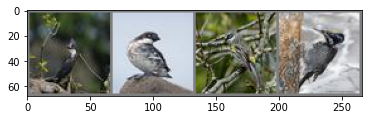

short , but large breasted brown bird with a rust colored crown and short bill .
a small bird with yellow and grey tones all over
this is a brown and black bird with a large downward pointing beak .
the little bird has a bright yellow chest accompanied by a grey and brown <unk> with white circles around its eyes .


In [10]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
def imshow(imgs):
  imgs = imgs / 2 + .5
  npimgs = imgs.numpy()
  plt.imshow(np.transpose(npimgs, (1, 2, 0)))
  plt.show()

dataiter =  iter(dataloader)
imgs, texts, lengths = next(dataiter)

imshow(torchvision.utils.make_grid(imgs[:4]))
for i in range(4):
  print(" ".join([vocab.idx2word[int(idx)] for t, idx in enumerate(texts[i]) if t < lengths[i]]))


**모델 정의**

In [44]:
# Hyper-parameters
num_epochs = 10
batch_size = 100
learning_rate_D = 0.001
learning_rate_G = 0.006
betas = (0.5, 0.999)

n_layers = 2
latent_dim = 512
t_hidden_dim = 256
t_out_dim = 512
embed_dim = 100
img_size = 64
vocab_size = len(vocab.word2idx)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
class Text_encoder(nn.Module):
  def __init__(self):
    super(Text_encoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embed_dim)

    self.LSTM = nn.LSTM(embed_dim, t_hidden_dim, num_layers = n_layers, batch_first = True)
    self.fc1 = nn.Linear(t_hidden_dim , t_out_dim)
    self.fc2 = nn.Linear(t_hidden_dim , t_out_dim)

  def forward(self, text):
    # text : (batch_size, max_seq_len)
    batch_size = text.size(0)
    t_emb = self.embedding(text)

    h0 = torch.zeros(n_layers, batch_size, t_hidden_dim).to(device)
    c0 = torch.zeros(n_layers, batch_size, t_hidden_dim).to(device)

    _, (h_n, _) = self.LSTM(t_emb, (h0, c0))
    final_hidden_1 = h_n[0]
    final_hidden_2 = h_n[1]
    out1 = self.fc1(final_hidden_1)
    out2 = self.fc2(final_hidden_2)
    out = torch.cat([out1, out2], dim = -1)

    return out

In [39]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.t_fc = nn.Linear(t_out_dim * 2, 128)
    self.z_fc = nn.Sequential(nn.Linear(128 + latent_dim, 128 * 8 * 8), nn.LeakyReLU(0.2, inplace = True))

    self.upsample = nn.Sequential(
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(128, 128, kernel_size = 3 ,stride = 1, padding = 1),
        nn.BatchNorm2d(128, 0.8),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(128, 64, kernel_size= 3, stride = 1, padding = 1),
        nn.BatchNorm2d(64, 0.8),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(64, 3, kernel_size = 3, stride = 1, padding = 1),
        nn.Tanh(),
    )

  def forward(self, z, t_emb):
    """
    z : latent vector, shape of  (batch_size, latent_dim)
    t_emb : text descriptions, shape of (batch_size, text_emb_dim( = 1024))
    """
    t_emb = self.t_fc(t_emb)
    conditioned_z = torch.cat([z, t_emb], dim = -1)
    out = self.z_fc(conditioned_z)
    out = out.view(-1, 128, 8, 8)
    out = self.upsample(out)
    return out


In [40]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.t_fc = nn.Sequential(nn.Linear(1024, 128), nn.ReLU())

    def Block(in_channels, out_channels, bn = True):
      module = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)]
      if bn:
        module.append(nn.BatchNorm2d(out_channels))
      module.append(nn.LeakyReLU(0.2, inplace = True))
      module.append(nn.Dropout(0.25))
      return module

    self.downsample = nn.Sequential(
        *Block(3, 32, bn = False),
        *Block(32, 64),
        *Block(64, 128),
        *Block(128, 256),   # (batch_size, 256, 4, 4)
    )

    self.conv1x1 = nn.Conv2d(256 + 128, 256, kernel_size = 1)
    self.final_conv = nn.Conv2d(256, 1, kernel_size = 4)

  def forward(self, imgs, text):
    """
    imgs : images, shape of (batch_size, 3 ,64, 64)
    text : text descriptions embedding , shape of (batch_size, 1024)
    """

    t_emb = self.t_fc(text).unsqueeze(2).unsqueeze(3).repeat(1, 1, 4, 4).clone()   # (batch_size, 128, 4, 4)
    out = self.downsample(imgs)    # (batch_size, 256, 4, 4)
    out = torch.cat([out, t_emb], dim = 1)
    out = self.conv1x1(out)
    out = self.final_conv(out).squeeze(3).squeeze(2)

    return out


In [41]:
text_encoder = Text_encoder().to(device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [45]:
adversarial_loss = nn.MSELoss()
optimizer_G = torch.optim.Adam(list(generator.parameters()) + list(text_encoder.parameters()), lr = learning_rate_G , betas = betas)
optimizer_D = torch.optim.Adam(list(discriminator.parameters()) + list(text_encoder.parameters()), lr = learning_rate_D, betas = betas)

Epoch [1 / 10], Generator Loss : 1.7134283781051636, Discriminator Loss : 0.04631071910262108


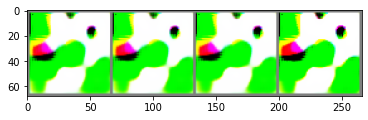

the bird has small beak when compared to its body with yellow throat , breast and brown tarsus and feet .
a small plump bird with a black head and white belly , the bill is pale pink and pointed , there is a pale tan color on its sides and it has a brown back and wings .
this bird is nearly all white with gray wing and yellow feet .
this bird is a medium sized white and gray bird with a spotted appearance because his plumage is <unk> and he has a long , sharp , black pointy bill for <unk> <unk> as he is sitting on a tree <unk> in the water , and his crown is spiked .
Epoch [2 / 10], Generator Loss : 2.1446175575256348, Discriminator Loss : 0.03674055635929108


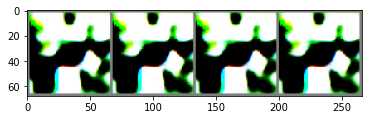

a yellow billed big swimming bird with a brown and light brown speckled body .
this is a red bird with brown wings and a small beak .
this <unk> colored bird with grey , black and light yellow highlights has mottled feathers and a large , sturdy body .
a mostly grey bird with a black tail and a white ring around the neck .
Epoch [3 / 10], Generator Loss : 2.214308977127075, Discriminator Loss : 0.49607670307159424


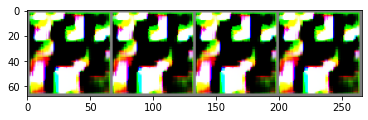

a small bird has a brown spotted crown , a white belly , and small brown feet .
the bird is round with yellow feathers and green accents .
a brightly colored yellow breasted bird with a black crown and cheek patch .
this small bird has a black and gray crown , gray nape and neck , and white wingbars on gray wings .
Epoch [4 / 10], Generator Loss : 2.018781900405884, Discriminator Loss : 0.33108100295066833


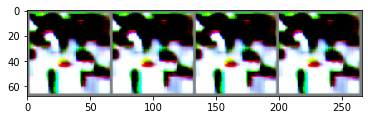

aquatic bird with very red eyes and brown/white feathers and a <unk> black bill
bird with read and brown feathers , medium length beak , and small claws .
the bird has a narrow , large bill , blue and white cheek patch , and black plumage across its back
this bird has a very long , thin , narrow pointed beak .
Epoch [5 / 10], Generator Loss : 1.9503185749053955, Discriminator Loss : 0.25804564356803894


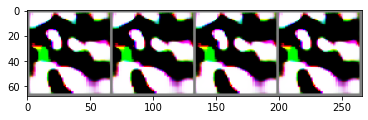

a small bird with a very long , narrow and pointy beak , the chest and belly are grayish blue and the wings are black with a green shimmer
this is a large black bird with a long neck and bright orange cheek patches .
this bird has a white belly and breast , a gray head and wings , and a gray tail .
the little bird has a bright yellow chest accompanied by a grey and brown <unk> with white circles around its eyes .
Epoch [6 / 10], Generator Loss : 2.3084592819213867, Discriminator Loss : 0.024659061804413795


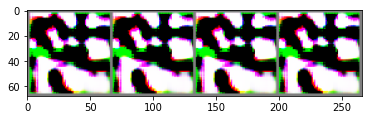

this bird has a white belly and breast , brown crown and wings , and a white eyebrow and cheek patch .
vibrant small bird with black beak , tarsus and feet along with bright red crown and breast and black wings and cheek patch .
this bird has a yellow belly with brown wings and head .
this bird has a yellow patch on it 's head , a black beak , with a grey and white body .
Epoch [7 / 10], Generator Loss : 2.301180124282837, Discriminator Loss : 0.042526975274086


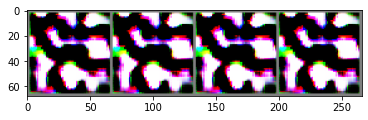

a small bird with a little round body and two stripes on its head .
this bird has a thin straight bill , black tarsus and feet with a black crown .
the bird has grayish white throat and belly and gray breast and nape with black tarsus and feet .
a mostly yellow bird with brown feathers in its wings and head .
Epoch [8 / 10], Generator Loss : 1.1920840740203857, Discriminator Loss : 0.15936201810836792


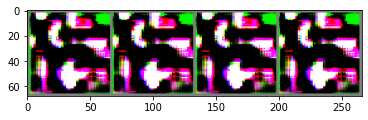

this bird has a white breast and belly with dark grey feathers and a small beak .
a small bird with white and brown wingbars , with a white breast and belly .
the bird has a thin , pointed beak , speckled black and white underside , and brown primaries , secondaries , and wingbars
this is a small bird with light brown feathers and thin black streaks on the crown and over the eyes .
Epoch [9 / 10], Generator Loss : 2.160144090652466, Discriminator Loss : 0.03167938441038132


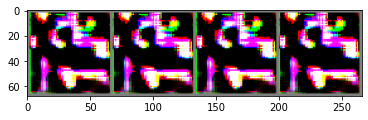

a very small bird with a bright yellow crown , black eyebrow , white belly with brown flank with grey and white wings and tail .
a small bird with black and white nape , black cheek patch and a long bill
this small brown bird has brown wings , and a small head compared to the rest of the body .
the bird has a small black bill that is curved .
Epoch [10 / 10], Generator Loss : 2.140748977661133, Discriminator Loss : 0.02713904157280922


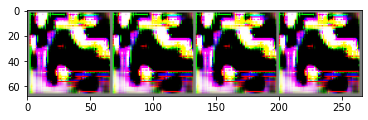

a round bird with a grey belly and an orange crown .
this bird is black overall , with an iridescent sheen on it 's head , neck and back , and a bright white rump .
a bird with a long pointed bill , white nape , and black and white spots covering its wings .
this bird is mostly gray with a black crest , and orange bill and feet .


In [46]:
with torch.autograd.set_detect_anomaly(True):
  clip = 1
  for epoch in range(num_epochs):
    for imgs, texts, lengths in dataloader:
      real_imgs, texts = imgs.to(device), texts.to(device)

      real_t_emb = text_encoder(texts)
      
      rand_ind = np.random.randint(6000, size = 10)
      ts = [CUB_200.call_text(idx) for idx in rand_ind]
      lens = [len(text) for text in ts]
      unmatched_texts = torch.zeros(10, max(lens)).long().to(device)
      for i, idx in enumerate(rand_ind):
        end = lens[i]
        unmatched_texts[i, :end] = ts[i][:end]

      fake_t_emb = Variable(text_encoder(unmatched_texts), requires_grad = False)
      

      z = torch.normal(mean = 0, std = 1, size = (imgs.size(0), latent_dim)).to(device)

      generated_imgs = generator(z, real_t_emb)

      real = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad = False)
      fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad = False)
      fake10 = Variable(torch.cuda.FloatTensor(10, 1).fill_(0.0), requires_grad = False)
    

      # For Learning with manifold interpolation
      int_ind = torch.LongTensor(np.random.randint(imgs.size(0), size = batch_size))
      shuffled_texts = texts[int_ind]
      shuffled_t_emb = text_encoder(shuffled_texts)
      interpolated_t_emb = (real_t_emb + shuffled_t_emb) / 2
      interpolated_fake_imgs = generator(z, interpolated_t_emb)
      

      #----------------------
      # Train the Generator
      #----------------------
      optimizer_G.zero_grad()
    
      loss_fake = adversarial_loss(discriminator(generated_imgs, real_t_emb), real)
      loss_int = adversarial_loss(discriminator(interpolated_fake_imgs, interpolated_t_emb), real)
      loss_G = loss_fake + loss_int
      loss_G.backward(retain_graph= True)

      torch.nn.utils.clip_grad_norm_(text_encoder.parameters(), clip)
      torch.nn.utils.clip_grad_norm_(generator.parameters(), clip)

      


      #-------------------------
      # Train the Discriminator
      #-------------------------
      optimizer_D.zero_grad()

      real_img_loss = adversarial_loss(discriminator(real_imgs, real_t_emb), real)
      wrong_t_loss =  adversarial_loss(discriminator(real_imgs[:10], fake_t_emb), fake10)
      fake_img_loss = adversarial_loss(discriminator(generated_imgs.detach(), real_t_emb), fake)
      loss_D = real_img_loss + (wrong_t_loss + fake_img_loss) / 2
      loss_D.backward()

      torch.nn.utils.clip_grad_norm_(discriminator.parameters(), clip)
      
      optimizer_G.step()
      optimizer_D.step()

    print(f"Epoch [{epoch + 1} / {num_epochs}], Generator Loss : {loss_G.item()}, Discriminator Loss : {loss_D.item()}")
    if (epoch + 1) % 1 == 0:
      torch.save(text_encoder.state_dict(), "text_enc.ckpt")
      torch.save(generator.state_dict(), "gen.ckpt")
      torch.save(discriminator.state_dict(), "dis.ckpt")
      imshow(torchvision.utils.make_grid(generated_imgs[:4].detach().cpu()))
      for i in range(4):
        print(" ".join([vocab.idx2word[int(idx)] for t, idx in enumerate(texts[i]) if t < lengths[i]]))

